In [ ]:
pip install torchvision pytorch

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


In [15]:
pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.27.1, but you have requests 2.25.1 which is incompatible.
tweepy 4.13.0 requires requests<3,>=2.27.0, but you have requests 2.25.1 which is incompatible.
yfinance 0.2.21 requires requests>=2.26, but you have requests 2.25.1 which is incompatib

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 61958983.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


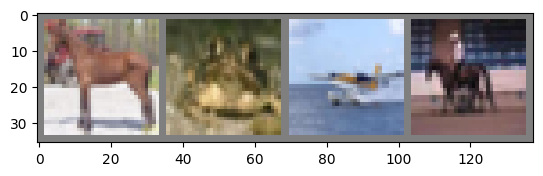

horse frog  plane horse


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Define a Convolutional Neural Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Classification Cross-Entropy loss and SGD with momentum.

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Data iterator, and feed the inputs to the network and optimize.

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.151
[1,  4000] loss: 1.783
[1,  6000] loss: 1.659
[1,  8000] loss: 1.537
[1, 10000] loss: 1.493
[1, 12000] loss: 1.458
[2,  2000] loss: 1.369
[2,  4000] loss: 1.357
[2,  6000] loss: 1.328
[2,  8000] loss: 1.309
[2, 10000] loss: 1.296
[2, 12000] loss: 1.259
Finished Training


In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


### Select image

In [29]:
image, label = testset[13]
image = image.unsqueeze(0) #add an extra dimension to the image tensor
label = torch.tensor([label])

In [30]:
# Fit Image Values to Range [0, 1]
image = torch.clamp(image, min=0.0, max=1.0)

### L2 norm PGD attack

In [37]:
import torchattacks
import torchvision.transforms as transforms

atk = torchattacks.PGDL2(net, eps=0.6, alpha=0.3, steps=7, random_start=True)
adv_image = atk(image, label)

### Get the predictions

In [39]:
with torch.no_grad():
    outputs = net(image)
    _, predicted = torch.max(outputs, 1)
    _, adv_predicted = torch.max(net(adv_image), 1)

tensor([7])
tensor([2])


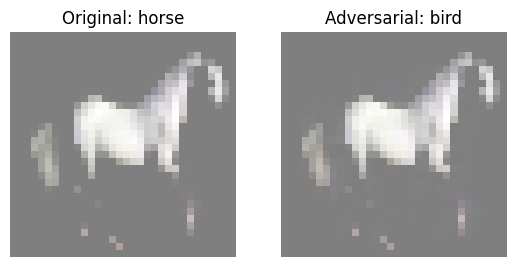

In [40]:
def imshow(img):
    img = img / 2 + 0.5  # Denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

plt.subplot(1, 2, 1)
imshow(image.cpu().squeeze())
print(predicted)
plt.title('Original: {}'.format(classes[predicted.item()]))

plt.subplot(1, 2, 2)
imshow(adv_image.cpu().squeeze())
plt.title('Adversarial: {}'.format(classes[adv_predicted.item()]))
print(adv_predicted)

plt.show()

In [41]:
with torch.no_grad():
    for images, labels in testloader:
        images = images
        labels = labels
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        break


accuracy = (predicted[0] == labels[0]).item() * 100.0

print("Accuracy to first label: {:.2f}%".format(accuracy))

Accuracy to first label: 100.00%


In [42]:
correct = 0
total = 0

# Realizar predicciones en la imagen original
with torch.no_grad():
    outputs = net(image)
    _, predicted = torch.max(outputs, 1)


with torch.no_grad():
    outputs_adv = net(adv_image)
    _, adv_predicted = torch.max(outputs_adv, 1)

total += 1
correct += (adv_predicted == label).sum().item()

print(f'Accuracy of the adversarial image: {100 * correct // total} %')


Accuracy of the adversarial image: 0 %


In [63]:
image, label = testset[23]
image = image.unsqueeze(0) #add an extra dimension to the image tensor
label = torch.tensor([label])

In [64]:
# Fit Image Values to Range [0, 1]
image = torch.clamp(image, min=0.0, max=1.0)

In [65]:
atk = torchattacks.PGD(net, eps=8/255, alpha=2/225, steps=10, random_start=True)
adv_image = atk(image, label)

In [66]:
with torch.no_grad():
    outputs = net(image)
    _, predicted = torch.max(outputs, 1)
    _, adv_predicted = torch.max(net(adv_image), 1)

tensor([9])
tensor([3])


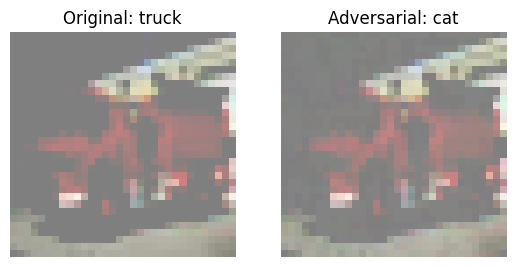

In [67]:
plt.subplot(1, 2, 1)
imshow(image.cpu().squeeze())
print(predicted)
plt.title('Original: {}'.format(classes[predicted.item()]))

plt.subplot(1, 2, 2)
imshow(adv_image.cpu().squeeze())
plt.title('Adversarial: {}'.format(classes[adv_predicted.item()]))
print(adv_predicted)

plt.show()